In [ ]:
import sys
sys.path.append("../src/models/")
sys.path.append("../src/")

In [7]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
from build import build_model
from torchsummary import summary

In [8]:
%load_ext autoreload
%autoreload 2

In [14]:
model_type='unet'
problem='denoise'
prefix = ''

In [10]:
model = build_model(model_type,'denoising')
summary(model, (1, 224, 224), device='cpu')

Using cache found in /Users/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 1, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 224, 224]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-6                    [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─Sequential: 2-3                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-8             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-9                    [-1, 64, 112, 112]        --
|    |

Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 1, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 224, 224]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-6                    [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─Sequential: 2-3                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-8             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-9                    [-1, 64, 112, 112]        --
|    |

In [15]:
from noiseadding import complex_noise_transforms, strong_noise_transforms
if prefix:
    noise_transforms = strong_noise_transforms
else:
    noise_transforms = complex_noise_transforms

In [17]:
from data import get_train_val_dataset, get_dataset
denoise_dataset = get_dataset(problem, noise_transforms=noise_transforms)

In [18]:
batch_size=8
workers=4
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print('Dataset size (num. batches)', len(train_loader), len(valid_loader))

Dataset size (num. batches) 239 27


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.

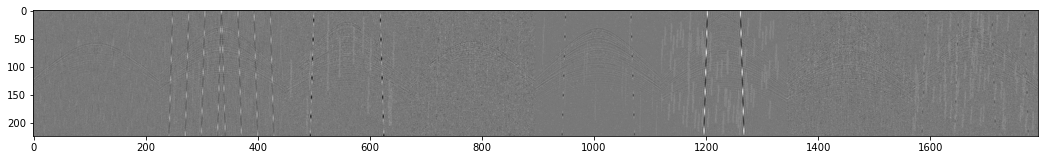

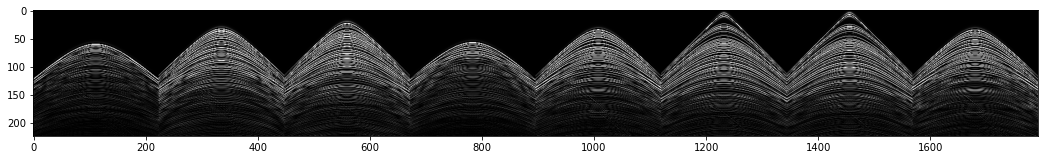

In [21]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['input'], padding=0)[0][None,...].permute((1, 2, 0)), cmap='gray')
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['target'].float(), padding=0).permute((1, 2, 0)))
#sample['target']

In [28]:
METADATA = '../metadata/'
save_file = "large_noisedenoise_model_unet_problem_denoise_gpu_n30_bs8_lr5e-05_pretrained.pkl"
save_path = os.path.join(METADATA, save_file)
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input']
y_pred, y = model(x), sample['target']

/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.

TypeError: Invalid shape (224, 224, 8) for image data

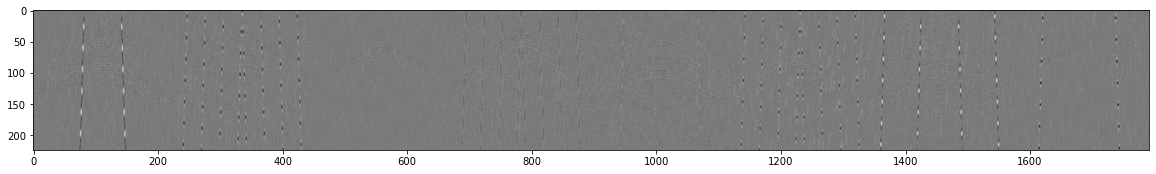

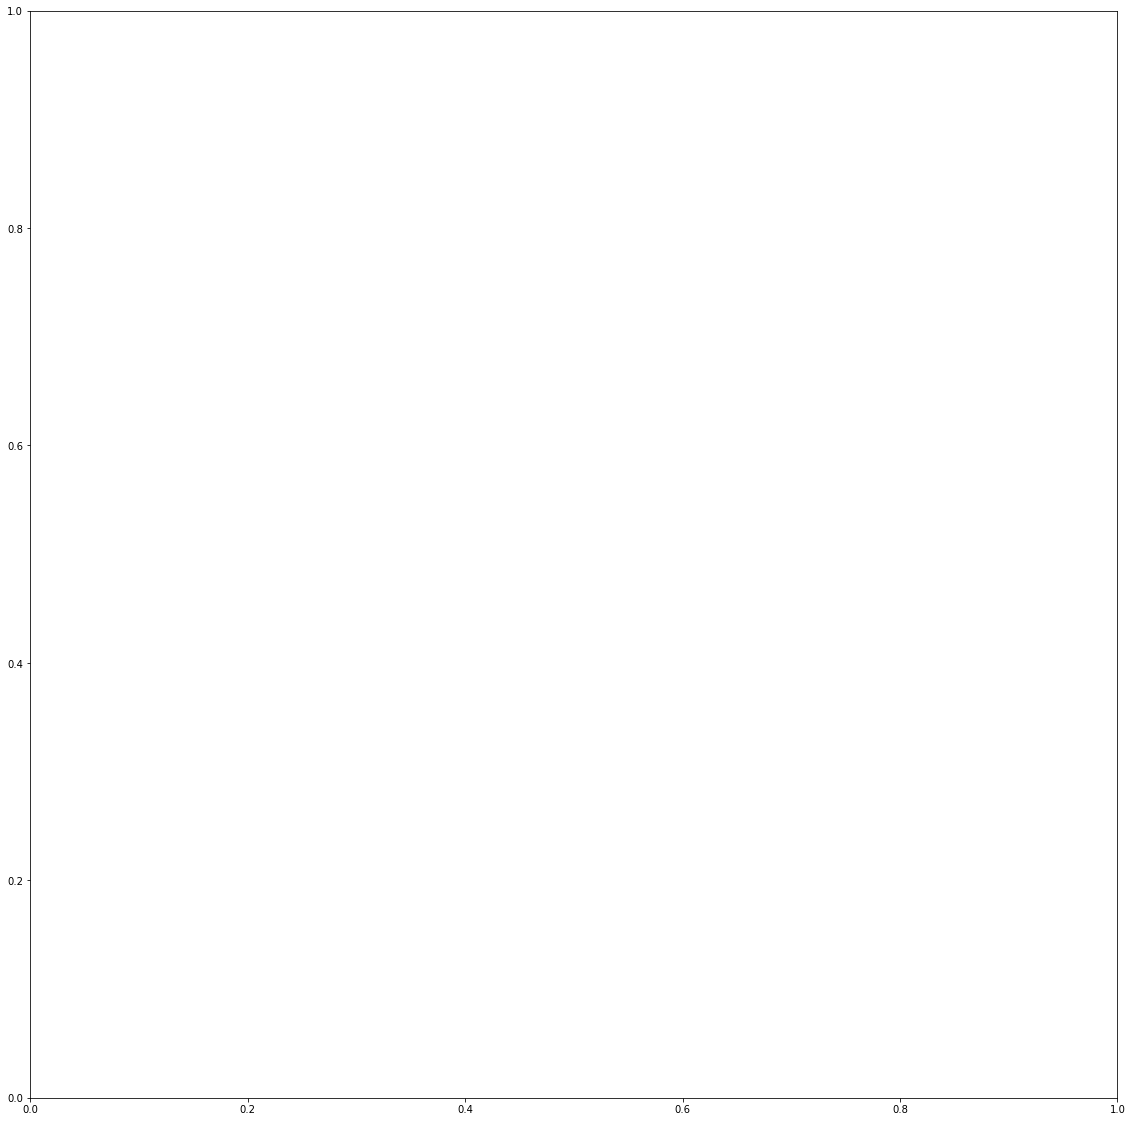

In [59]:
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0)[0][None,...].permute((1, 2, 0)), cmap='gray')
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0).permute((1, 2, 0)))

In [48]:
model_type='unet'
problem='firstbreak'
prefix = ''

In [50]:
model = build_model(model_type,problem)
summary(model, (1, 224, 224), device='cpu')

Using cache found in /Users/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 2, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 224, 224]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-6                    [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─Sequential: 2-3                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-8             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-9                    [-1, 64, 112, 112]        --
|    |

Layer (type:depth-idx)                   Output Shape              Param #
├─UNet: 1-1                              [-1, 2, 224, 224]         --
|    └─Sequential: 2-1                   [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        288
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─Conv2d: 3-4                  [-1, 32, 224, 224]        9,216
|    |    └─BatchNorm2d: 3-5             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-6                    [-1, 32, 224, 224]        --
|    └─MaxPool2d: 2-2                    [-1, 32, 112, 112]        --
|    └─Sequential: 2-3                   [-1, 64, 112, 112]        --
|    |    └─Conv2d: 3-7                  [-1, 64, 112, 112]        18,432
|    |    └─BatchNorm2d: 3-8             [-1, 64, 112, 112]        128
|    |    └─ReLU: 3-9                    [-1, 64, 112, 112]        --
|    |

In [51]:
from noiseadding import complex_noise_transforms, strong_noise_transforms
if prefix:
    noise_transforms = strong_noise_transforms
else:
    noise_transforms = complex_noise_transforms

In [52]:
from data import get_train_val_dataset, get_dataset
denoise_dataset = get_dataset(problem, noise_transforms=noise_transforms)

In [53]:
batch_size=8
workers=4
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
print('Dataset size (num. batches)', len(train_loader), len(valid_loader))

Dataset size (num. batches) 239 27


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:283: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.

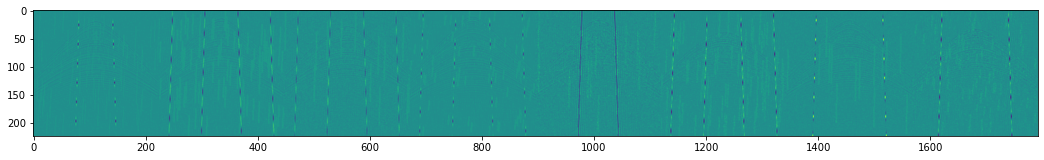

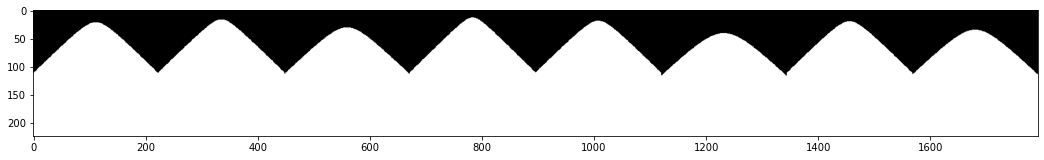

In [56]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['input'], padding=0)[0][None,...].permute((1, 2, 0)))

figure(figsize=(18,9))
imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
#sample['target']

In [57]:
METADATA = '../metadata/'
save_file = "large_noisewith_noise_model_unet_problem_firstbreak_gpu_n15_bs8_lr5e-05_pretrained.pkl"
save_path = os.path.join(METADATA, save_file)
model.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [58]:
model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['input']
y_pred, y = model(x), sample['target']

/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
/Users/makam0a/Dropbox/projects/denoising/seismic/src/noiseadding.py:278: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.

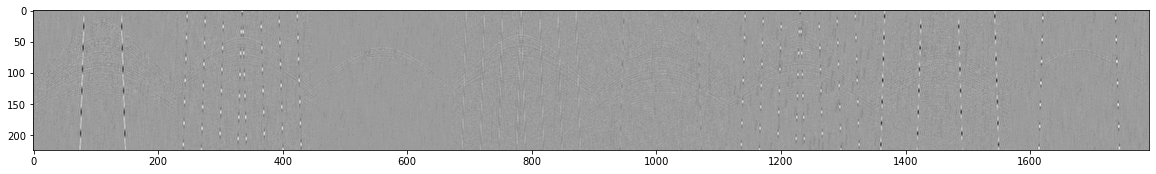

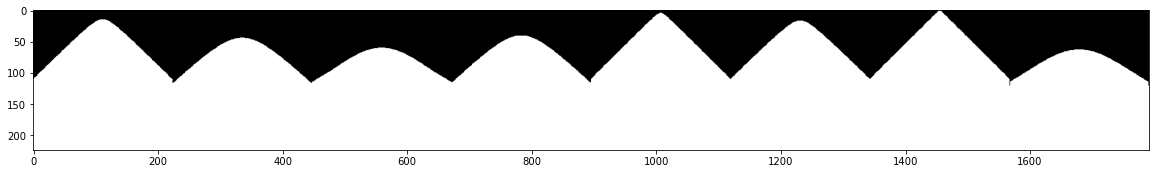

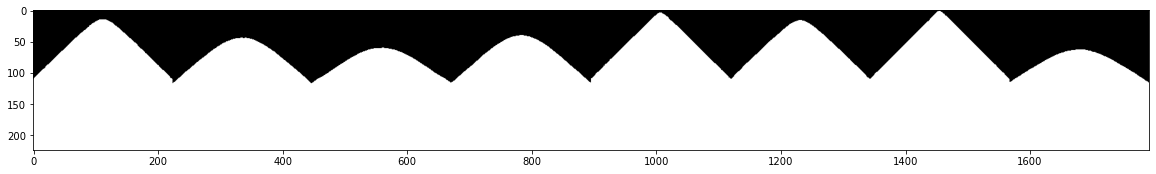

In [62]:
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['input'], padding=0)[0][None,...].permute((1, 2, 0)), cmap='Greys')
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['target'].float().unsqueeze(1), padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.argmax(dim=1).detach().cpu().float().unsqueeze(1), padding=0).permute((1, 2, 0)))